# DWT (Discrete Wavelet Transform)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
import image
import DWT
import pywt
import distortion
import YCoCg as YUV
import deadzone as Q

Wavelet = Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
DWT extension mode = periodization


In [2]:
wavelet = pywt.Wavelet("Haar")
#wavelet = pywt.Wavelet("db5")
#wavelet = pywt.Wavelet("bior3.1")
#wavelet = pywt.Wavelet("bior3.3")
print(wavelet)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [3]:
test_image = "../sequences/lena_color/"

In [4]:
N_levels = 5

In [5]:
Q_steps = [128, 64, 32, 16, 8, 4, 2, 1]

## First ... some handy routines

In [6]:
def read_image(prefix):
    x = image.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint16)
    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = decom[0] + 32768

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                decom[l+1][0] + 32768

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                decom[l+1][1] + 32768

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                decom[l+1][2] + 32768
            
    return image.write(view, prefix, image_number)
    
def read_compact_decomposition(prefix, image_number, N_levels):
    view = image.read(prefix, image_number)
    wavelet = pywt.Wavelet("Haar")
    decom = DWT.analyze(np.zeros_like(view), wavelet, N_levels)
    
    # LL subband
    decom[0][...] = view[0:decom[0].shape[0],
                         0:decom[0].shape[1]] - 32768
    
    for l in range(len(N_levels)):
        
        # LH
        decom[l+1][0] =\
            view[0:decom[l+1][0].shape[0],
                 decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] - 32668
            
        # HL
        decom[l+1][1] =\
            view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
                 0:decom[l+1][1].shape[1]] - 32768
            
        # HH
        decom[l+1][2] =\
            view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
                 decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] - 32768

    return decom

## Testing `DWT.analyze_step()` and `DCT.synthesize_step()`

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
component 0 239 8 uint16
component 1 248 1 uint16
component 2 255 54 uint16


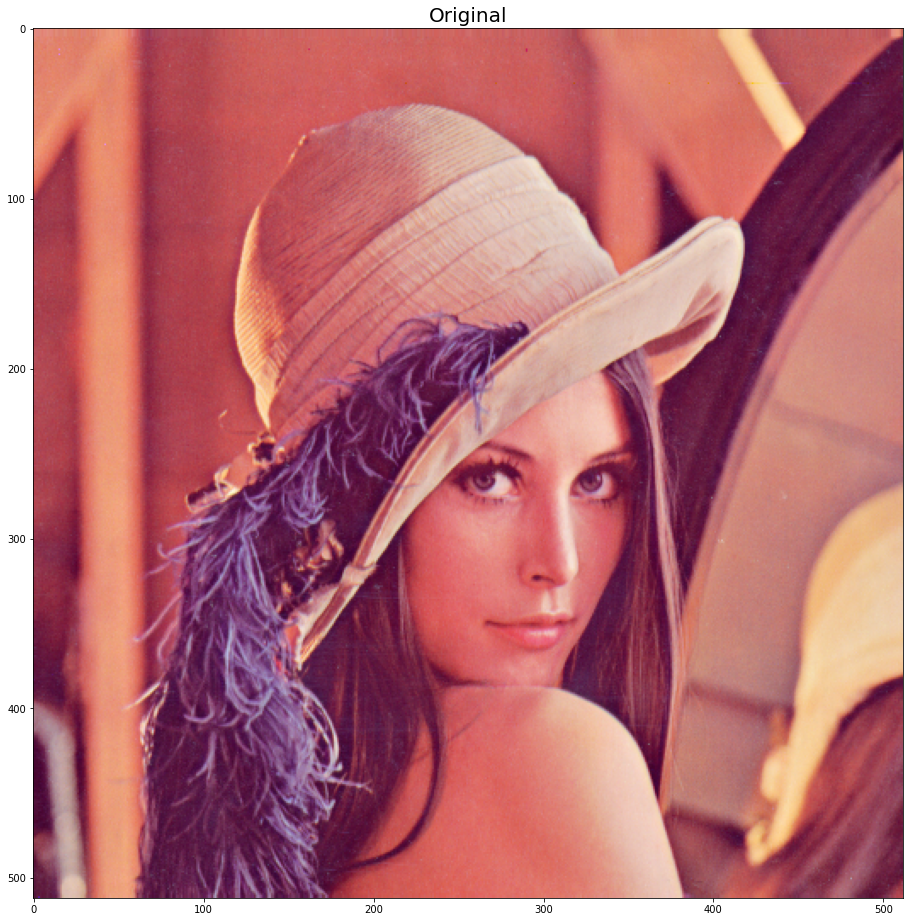

In [7]:
x = read_image(test_image)
image.show_RGB_image(x, title="Original")

In [8]:
L,H = DWT.analyze_step(x, wavelet)

component 0 213.21747765640515 42.03574975173784 float64
component 1 238.5402184707051 0.0 float64
component 2 255.0 55.20357497517379 float64
component 0 236.23096446700504 0.0 float64
component 1 255.0 5.177664974619306 float64
component 2 210.98984771573606 44.65736040609139 float64
component 0 225.4017857142857 21.857142857142833 float64
component 1 255.0 0.0 float64
component 2 222.66964285714286 46.901785714285715 float64
component 0 255.0 0.0 float64
component 1 207.36263736263737 29.890109890109837 float64
component 2 179.34065934065936 57.91208791208793 float64


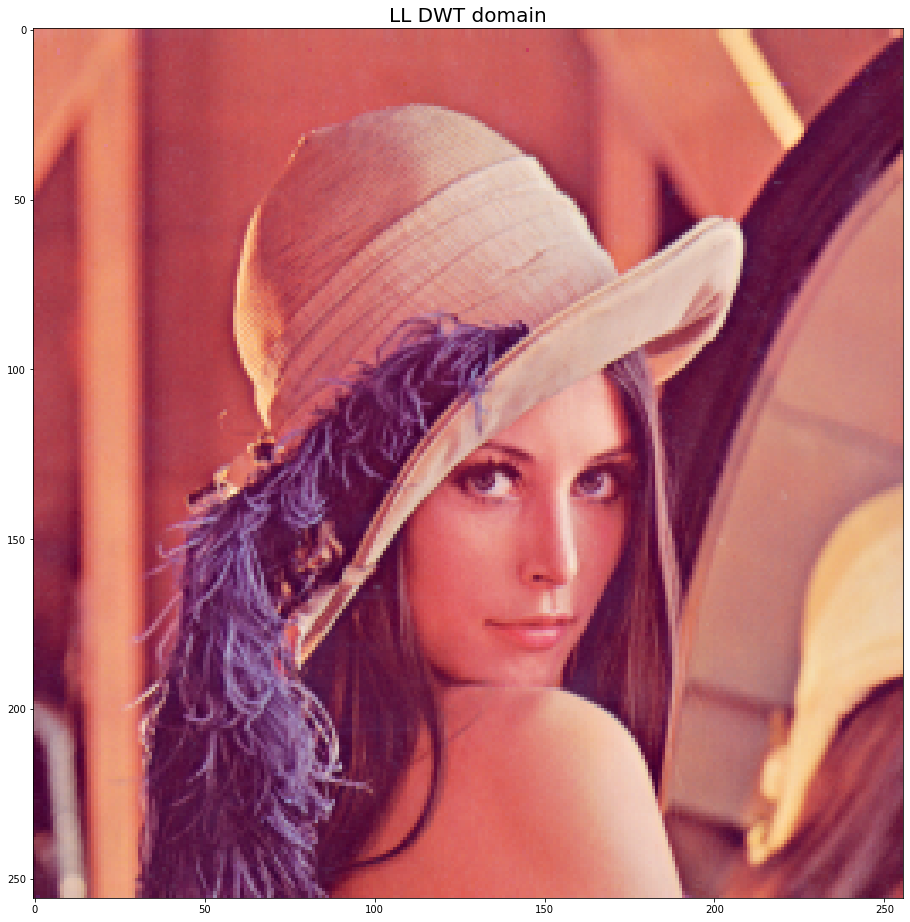

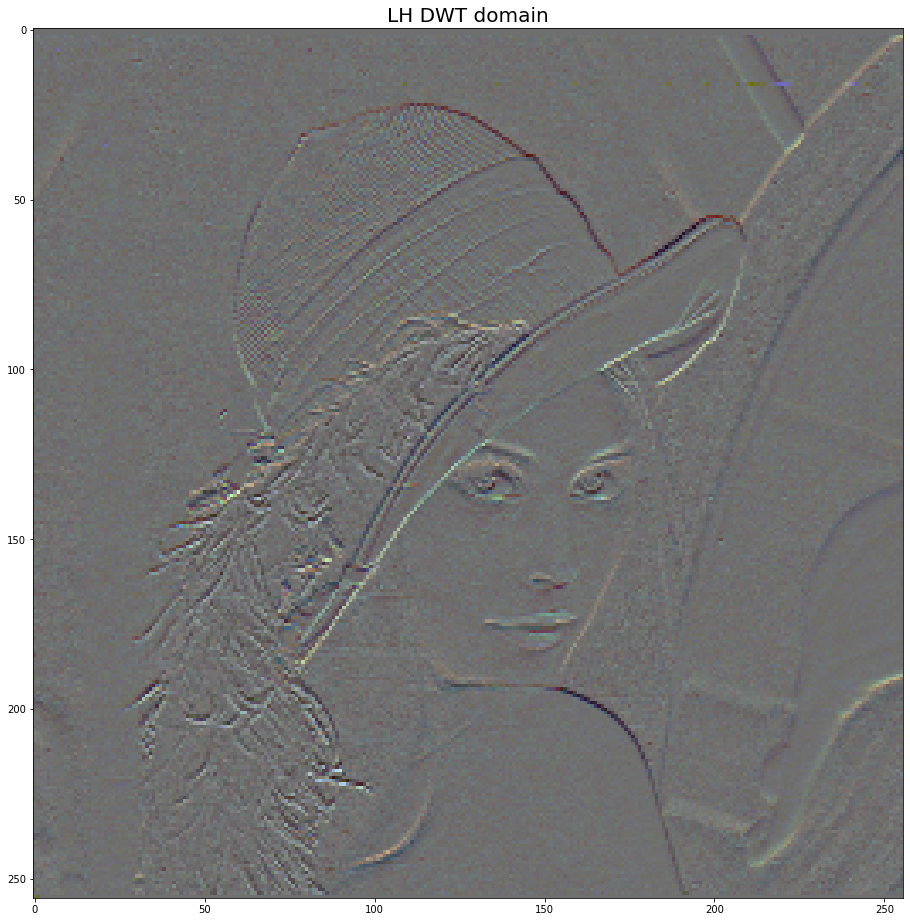

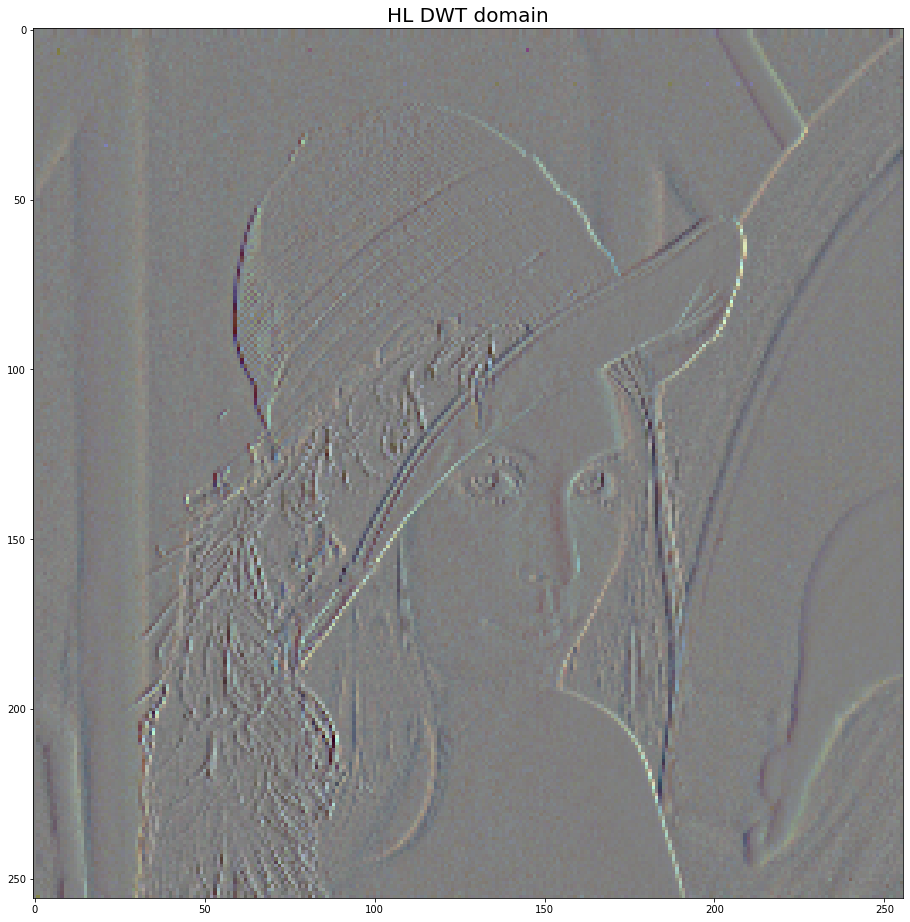

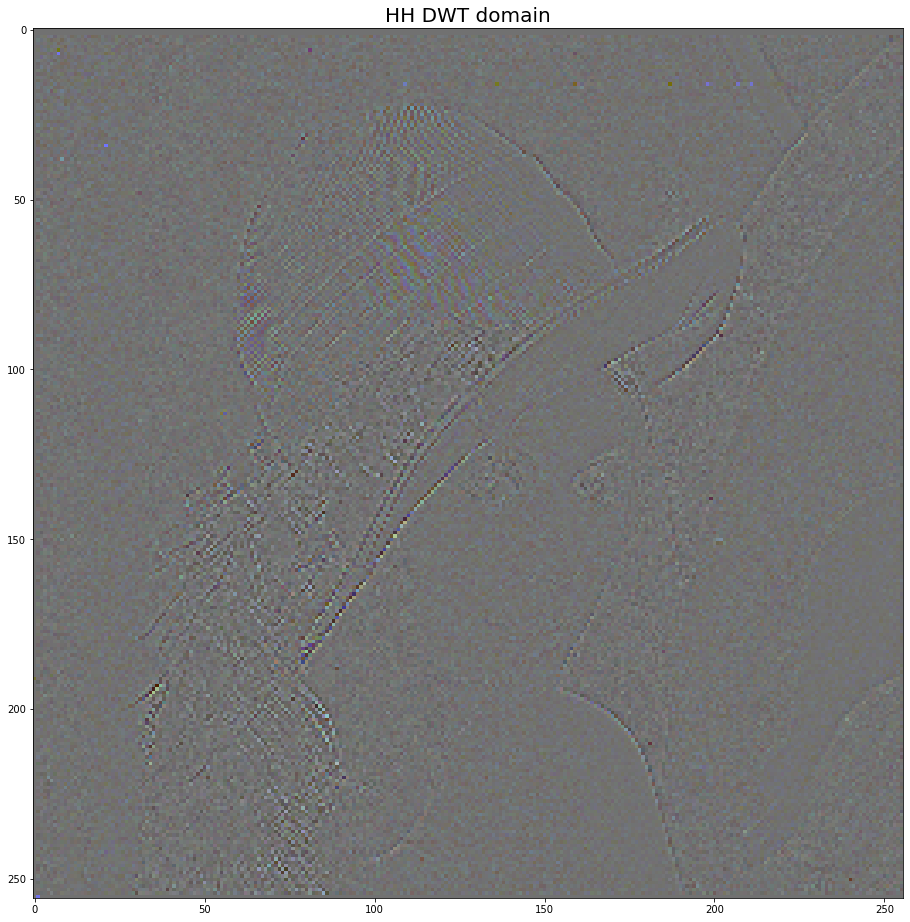

In [9]:
image.show_RGB_image(255*image.normalize(L), "LL DWT domain")
subbands = ("LH", "HL", "HH")
for i, sb in enumerate(subbands):
    image.show_RGB_image(255*image.normalize(H[i]), f"{sb} DWT domain")

In [10]:
z = DWT.synthesize_step(L, H, wavelet).astype(np.uint8)

In [11]:
r = x - z

component 0 255.0 0.0 float64
component 1 255.0 0.0 float64
component 2 255.0 0.0 float64


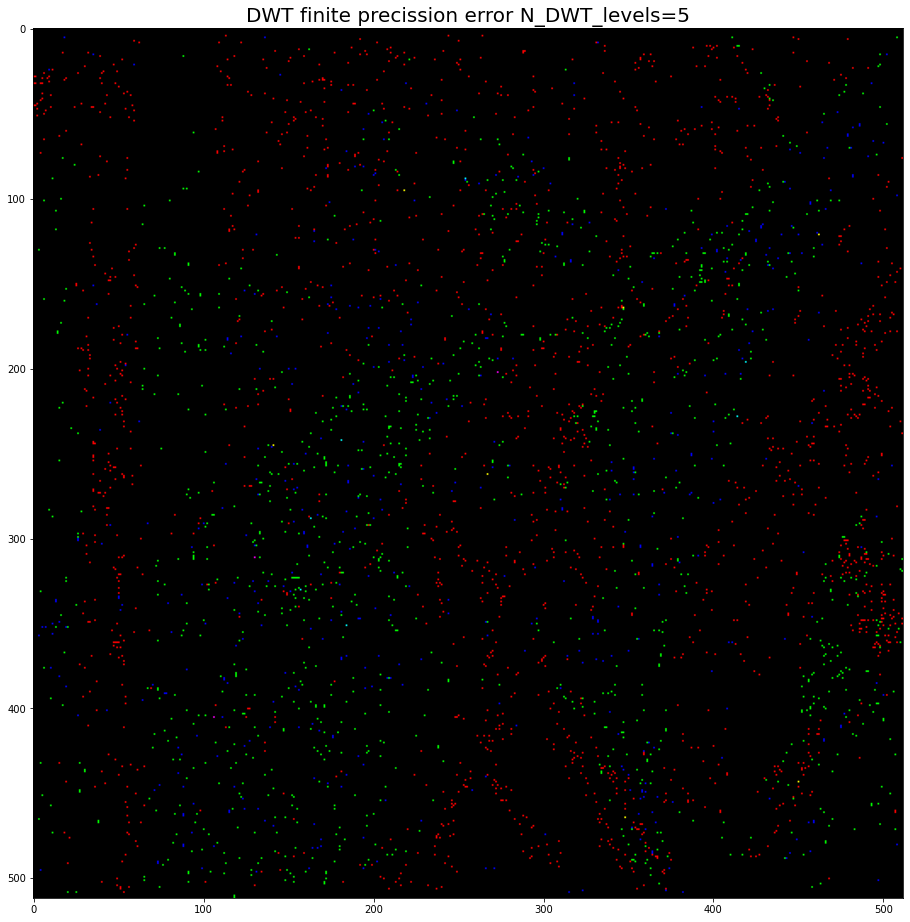

In [12]:
image.show_RGB_image(255*image.normalize(r), f"DWT finite precission error N_DWT_levels={N_levels}")

In [13]:
r.max()

1

The DCT is not fully reversible, but it is almost.

component 0 239 7 uint8
component 1 248 1 uint8
component 2 255 54 uint8


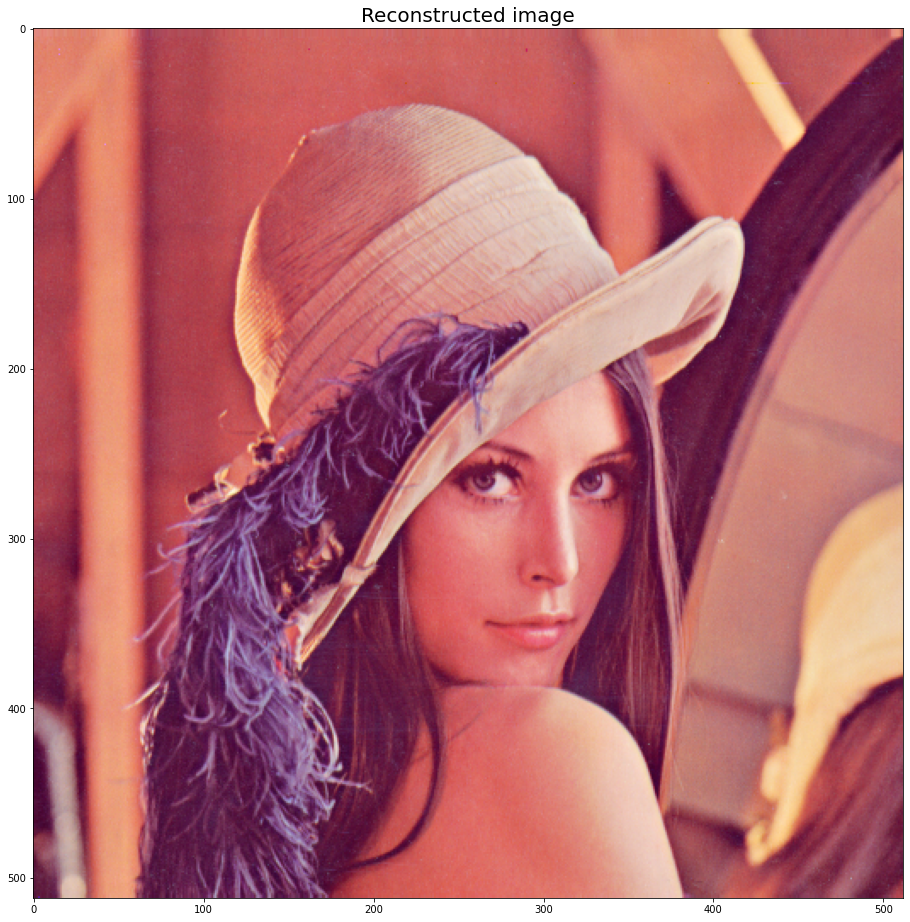

In [14]:
image.show_RGB_image(z, "Reconstructed image")

## Testing `DWT.analyze()` and `DCT.synthesize()`

In [15]:
y = DWT.analyze(x, wavelet, N_levels)
z = DWT.synthesize(y, wavelet, N_levels).astype(np.uint8)

In [16]:
r = x - z

In [17]:
r.max()

1

component 0 0.0 0.0 float64
component 1 255.0 0.0 float64
component 2 0.0 0.0 float64


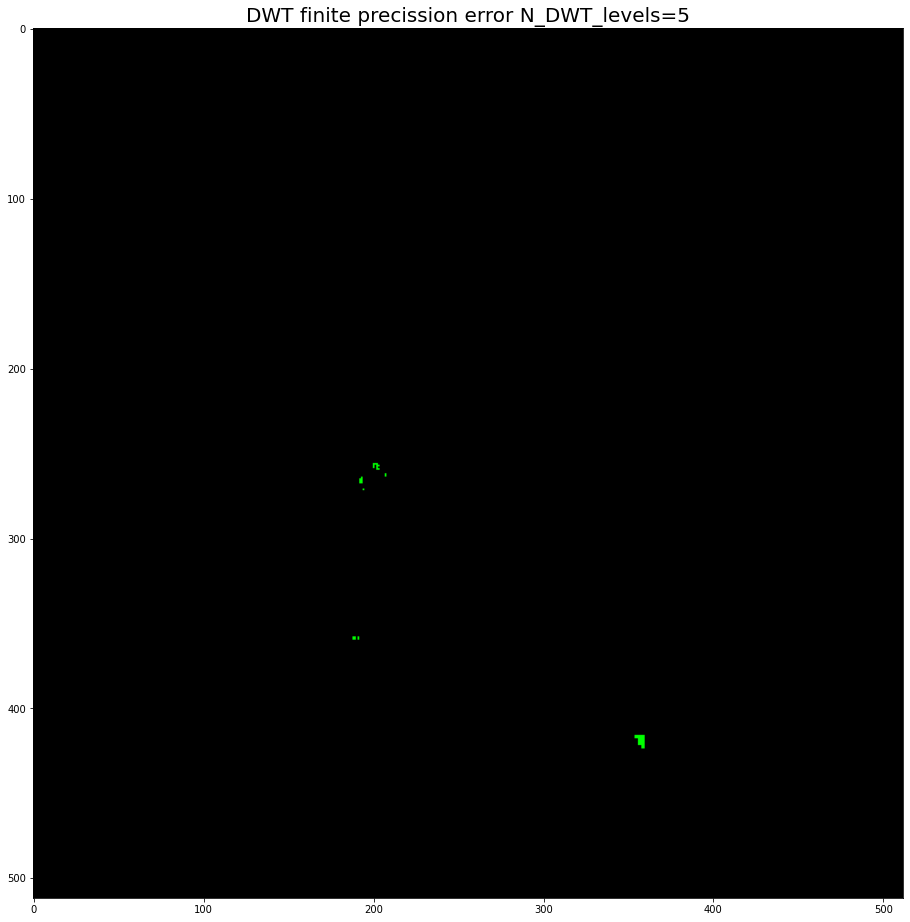

In [18]:
image.show_RGB_image(255*image.normalize(r), f"DWT finite precission error N_DWT_levels={N_levels}")

component 0 239 8 uint8
component 1 248 1 uint8
component 2 255 54 uint8


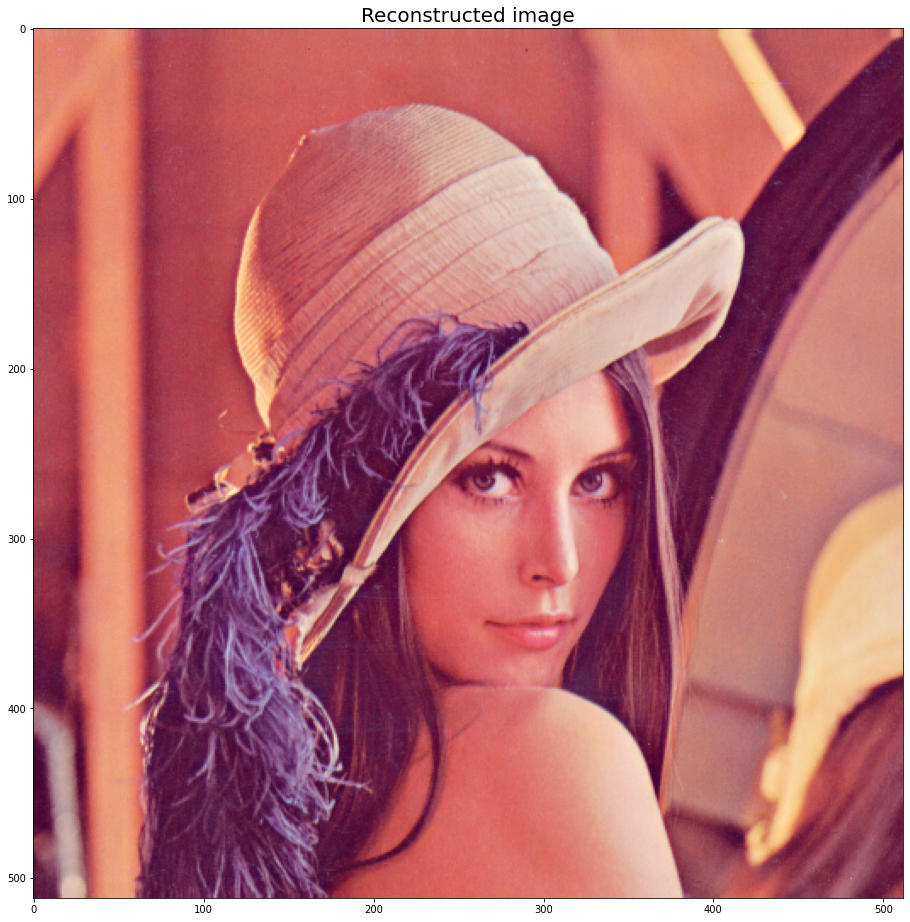

In [19]:
image.show_RGB_image(z, "Reconstructed image")

In [20]:
print(y[0].max(), y[0].min(), np.average(y[0]))
for sr in y[1:]:
    for sb in sr:
        print(sb.max(), sb.min(), np.average(sb))

7626.5625000000055 774.6562500000007 4103.393147786461
1474.5625000000007 -1672.3437500000014 0.5023600260416595
1749.8437500000016 -1511.7187500000005 -34.53719075520834
837.6875000000006 -929.6875000000005 -8.22224934895833
655.8750000000002 -760.8750000000005 3.0720621744791696
999.8750000000006 -1007.0000000000005 -4.391398111979169
495.9375000000002 -670.5000000000003 -0.08711751302083141
414.0000000000002 -467.1250000000002 0.8259684244791677
683.7500000000002 -484.25000000000017 -1.4345092773437507
244.50000000000014 -317.2500000000001 -0.22334798177083273
252.5000000000001 -204.00000000000009 0.10362752278645819
325.25 -259.50000000000006 -0.31182861328125006
129.25 -157.00000000000006 0.05757649739583348
111.00000000000003 -86.00000000000003 0.02682495117187501
140.00000000000003 -140.0 -0.12017822265625001
75.5 -61.0 0.002924601236979189


## An example of "constant" quantization

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
Distortion in the image domain: 16528.26793162028
Distortion in the wavelet domain: 97.66186269124348
component 0 216.00000000000006 23.999999999999957 float64
component 1 228.00000000000006 0.0 float64
component 2 255.0 63.999999999999915 float64


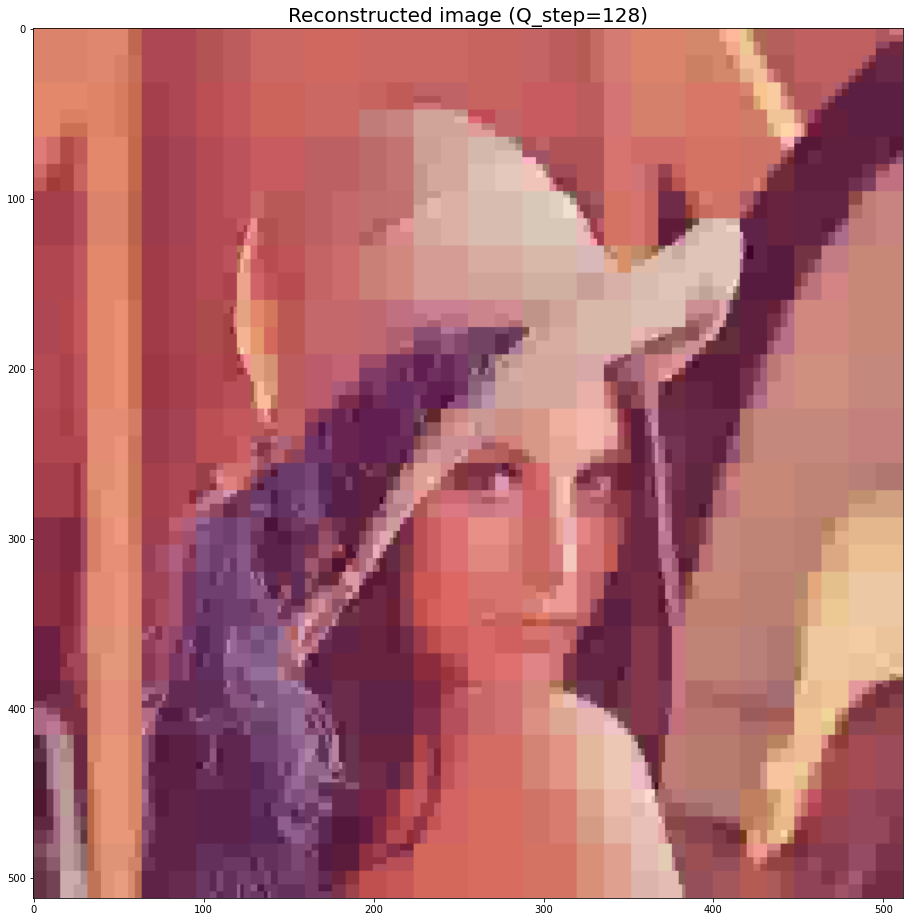

In [32]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
Q_step = 128

LL = y[0]
LL_k = Q.quantize(LL, Q_step)
LL_dQ = Q.dequantize(LL_k, Q_step)
dist = distortion.MSE(LL, LL_dQ)
MSE_wavelet_domain = dist * LL.size / x.size
counter = 1
y_dQ = [LL_dQ]
for sr in y[1:]:
    sr_dQ = []
    for sb in sr:
        sb_k = Q.quantize(sb, Q_step)
        sb_dQ = Q.dequantize(sb_k, Q_step)
        sr_dQ.append(sb_dQ)
        dist = distortion.MSE(sb, sb_dQ)
        MSE_wavelet_domain += ((dist * sb.size) / x.size)
    y_dQ.append(tuple(sr_dQ))

z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
zz_dQ = np.clip( YUV.to_RGB(z_dQ) + 128, a_min=0, a_max=255)
print("Distortion in the image domain:", distortion.MSE(xx, zz_dQ))
print("Distortion in the wavelet domain:", MSE_wavelet_domain)
image.show_RGB_image(zz_dQ, f"Reconstructed image (Q_step={Q_step})")

## An orthogonality test

Orthogonality is necessary to avoid that the quantization error generated in a subband does not affect to the rest of subband. This will speed up the RD optimization because the distortion can be measured in the DWT domain.

This orthogonality test does:
1. Compute the DWT of an image.
2. Set to zero all the subbands except one.
3. Compute the inverse DWT.
4. Compute the DWT again of the previous reconstruction.
5. Test if the decomposition matches the one generated in the step 2.  If matches (with some maximum error), the transform is orthogonal.

In [21]:
y = DWT.analyze(x, wavelet, N_levels)
subband_to_keep = 5
if subband_to_keep > DWT._N_levels:
    print("No way, José")
y[0][...] = 0.0
counter = 0
for sr in y[1:]:
    for sb in sr:
        if counter != subband_to_keep:
            sb[...] = 0.0
        counter += 1
z = DWT.synthesize(y, wavelet, N_levels)
#image.show_RGB_image(z, "Reconstructed image")
y2 = DWT.analyze(z, wavelet, N_levels)
counter = 0
orthogonal = True
for sr, sr2 in zip(y[1:], y2[1:]):
    for sb, sb2 in zip(sr, sr2):
        #print((sb == sb2).allclose())
        if not np.allclose(sb, sb2):
            orthogonal = False
        #if counter == subband_to_keep:
        #    image.show_RGB_image(sb)
        #    image.show_RGB_image(sb2)
        counter += 1
print("Orthogonal:", orthogonal)

Orthogonal: True


Another way to know if the transform is orthogonal is compute the quantization distortion in the wavelet domain and see if it is the same than the distortion in the image domain. 

## Forward transform gain

This information is important to known if the transform is unitary or not (usually, biorthogonal transform are not unitary, i.e., the energy of the decomposition is larger then the energy of the image).

In [22]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = distortion.average_energy(x)
print("Image energy:", image_energy)
decom_energy = distortion.average_energy(y[0])*y[0].size/x.size
for sr in y[1:]:
    for sb in sr:
        decom_energy += distortion.average_energy(sb)*sb.size/x.size
print("Decomposition energy", decom_energy)
print("Transform gain:", decom_energy/image_energy)

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
Image energy: 1439.2267634073894
Decomposition energy 1439.2267634073908
Transform gain: 1.0000000000000009


## Subband gains
The gain of each subband can be computed giving energy to a subband, performing the inverse transform, and measuring the energy of the reconstruction divided by the number of coefficients in the subband. The gains are important because the quantization error generated in a subband is multiplied by its gain in the reconstructed image. Notice that in the case of the DWT, the high-frequency subbands has more coefficients than the low-frequency subbands.

In [23]:
gains = []
y = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
y[0][...] = 1.0 
z = DWT.synthesize(y, wavelet, N_levels)
gains.append(distortion.energy(z)/np.size(y[0]))
prev_sb = y[0]
for sr in y[1:]:
    for sb in sr:
        prev_sb[...] = 0.0
        sb[...] = 1.0 
        z = DWT.synthesize(y, wavelet, N_levels)
        gains.append(distortion.energy(z)/np.size(sb))
        prev_sb = sb
print(gains)

[1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002]


## RD performance using "constant" quantization among subbands

In [25]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

DWT_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)
    y_k = []
    LL = y[0]
    LL_k = Q.quantize(LL, Q_step/gains[0])
    LL_dQ = Q.dequantize(LL_k, Q_step/gains[0])
    y_k.append(LL_k)
    dist = distortion.MSE(LL, LL_dQ)
    #MSE = (gains[0] * (dist * LL.size))/x.size
    MSE = (dist * LL.size)/x.size
    #print(gains[0], dist, gains[0] * dist, MSE)
    #for i in range(4):
    #    for j in range(4):
    #        print(LL[i, j], LL_dQ[i, j])
    counter = 1
    for sr in y[1:]:
        sr_k = []
        for sb in sr:
            #print(MSE)
            sb_k = Q.quantize(sb, Q_step/gains[counter])
            sb_dQ = Q.dequantize(sb_k, Q_step/gains[counter])
            sr_k.append(sb_k)
            dist = distortion.MSE(sb, sb_dQ)
            #print(gains[counter], dist, gains[counter] * dist, MSE)
            #MSE += (gains[counter] * (dist * sb.size))/x.size
            MSE += (dist * sb.size)/x.size
            counter += 1
        y_k.append(tuple(sr_k))
    BPP = (write_compact_decomposition(y_k, f"/tmp/constant_{Q_step}", 0)*8)/x.size
    print(f"{Q_step} {BPP} {MSE}")
    DWT_points.append((BPP, MSE))

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
image.write: /tmp/constant_128000.png (512, 512, 3) uint16 10388 
128 0.10567220052083333 97.66186269124351
image.write: /tmp/constant_64000.png (512, 512, 3) uint16 19542 
64 0.19879150390625 55.832715352376326
image.write: /tmp/constant_32000.png (512, 512, 3) uint16 40184 
32 0.4087727864583333 31.019676208496104
image.write: /tmp/constant_16000.png (512, 512, 3) uint16 78970 
16 0.8033243815104166 16.64112854003907
image.write: /tmp/constant_8000.png (512, 512, 3) uint16 159597 
8 1.623504638671875 8.331640243530277
image.write: /tmp/constant_4000.png (512, 512, 3) uint16 337150 
4 3.4296671549479165 3.3309529622395857
image.write: /tmp/constant_2000.png (512, 512, 3) uint16 538631 
2 5.479237874348958 0.9735541343688981
image.write: /tmp/constant_1000.png (512, 512, 3) uint16 698670 
1 7.10723876953125 0.23945617675781336


In [26]:
DCT_points = []
with open("DCT.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_points.append((float(rate), float(_distortion)))

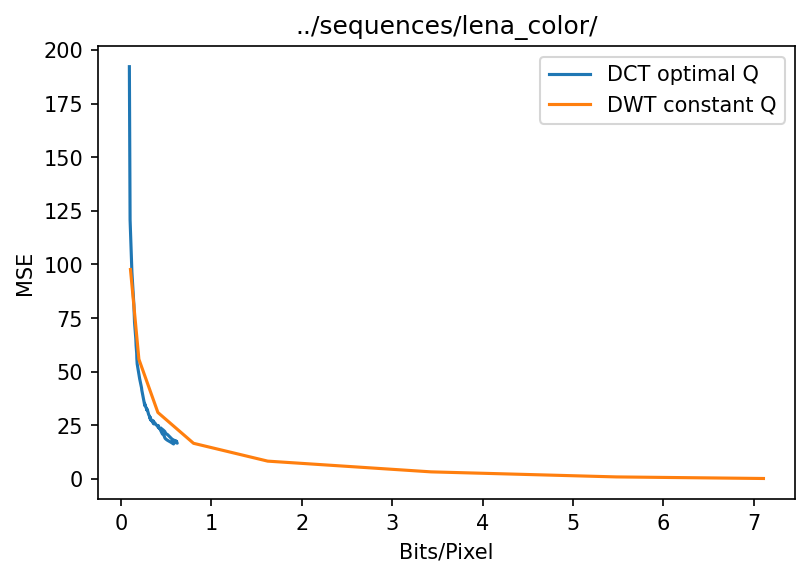

In [27]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_points), label=f"DCT optimal Q")
pylab.plot(*zip(*DWT_points), label=f"DWT constant Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Optimal quantization progression

Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.